<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by AkashNarayanan B and Özlem Salehi</td>    
</table>
<hr>

# BQM for the Travelling Salesman Problem

In this notebook, we will learn how to formulate BQM for the Travelling Salesman Problem. Instead of following the approach in the previous notebook, we will use the functions provided by Ocean SDK to formualate the binary quadratic model.


To briefly recall, given a set of cities and corresponding distances between each pair of cities, the goal is to find the shortest possible route such that a salesman visits every city exactly once and returns to the starting point. 

QUBO formulation for TSP was given as follows:

$$P \cdot \sum_{t=0}^{N-1} \left(1-\sum_{i=0}^{N-1}x_{i,t}\right)^2 + P \cdot \sum_{i=0}^{N-1} \left(1-\sum_{t=0}^{N-1}x_{i,t}\right)^2 + \sum_{ \substack{i,j=0\\i\neq j}}^{N-1} w_{ij} \sum_{t=0}^{N-1} x_{i,t} x_{j,t+1} $$


We will solve TSP problem both by using the built-in BQM constructor, by creating the BQM from scratch and by using the funcitonality of Ocean SDK to incorporate constraints into the model. 

### Imports

In [1]:
import itertools
from collections import defaultdict

import dimod
from dimod import BQM
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from neal import SimulatedAnnealingSampler
from dimod.reference.samplers import ExactSolver

from bqm_utils import graph_viz, tsp_viz

## Built-in Function

`travelling_salesperson` is the built-in function in the `dwave-networkx` package for solving the travelling salesman problem.

### Parameters

- `G` - The NetworkX graph
- `sampler` - BQM sampler for solving the NetworkX graph
- `start`(optional) - Starting point of the tour



### Example 1

Let us consider the following graph.

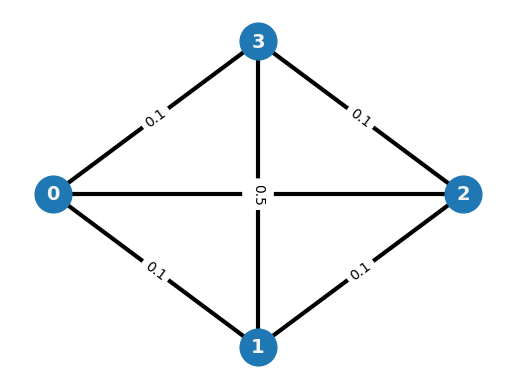

In [2]:
G = nx.Graph()
G.add_weighted_edges_from(
    {(0, 1, 0.1), (0, 2, 0.5), (0, 3, 0.1), (1, 2, 0.1), (1, 3, 0.5), (2, 3, 0.1)}
)
graph_viz(G)

We are going the use the classical solver `ExactSolver` for solving this problem.

In [3]:
sampler = ExactSolver()
path = dnx.traveling_salesperson(G, sampler, start=0)
print(path)

[0, 3, 2, 1]


Let us viusalize the result. 

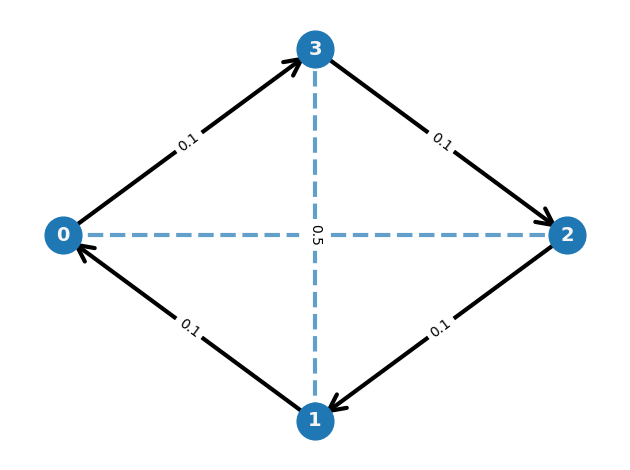

In [4]:
tsp_viz(G, path)

### Example 2

This time, let us create a complete graph with 6 vertices and assign random weights to each edge. 

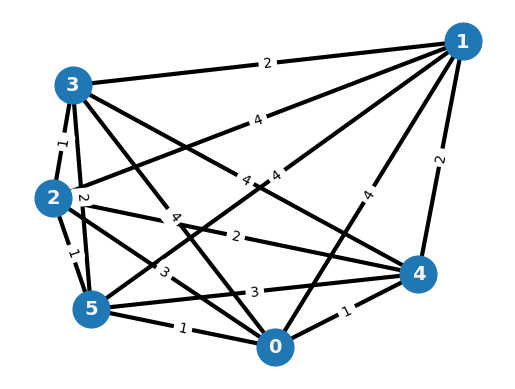

In [5]:
np.random.seed(45)
G1 = nx.complete_graph(6)
for u, v in G1.edges():
    G1[u][v]["weight"] = np.random.randint(1, 5)

graph_viz(G1)

In [6]:
list(G1.edges.data())

[(0, 1, {'weight': 4}),
 (0, 2, {'weight': 3}),
 (0, 3, {'weight': 4}),
 (0, 4, {'weight': 1}),
 (0, 5, {'weight': 1}),
 (1, 2, {'weight': 4}),
 (1, 3, {'weight': 2}),
 (1, 4, {'weight': 2}),
 (1, 5, {'weight': 4}),
 (2, 3, {'weight': 1}),
 (2, 4, {'weight': 2}),
 (2, 5, {'weight': 1}),
 (3, 4, {'weight': 4}),
 (3, 5, {'weight': 2}),
 (4, 5, {'weight': 3})]

If you try using the `ExactSolver` with this instance, you may not be successfull depending on your computer's memory. Hence we will use `SimulatedAnnealingSampler` instead.

In [7]:
sampler = SimulatedAnnealingSampler()

path = dnx.traveling_salesperson(G1, sampler, start=0)
print(path)

[0, 2, 5, 3, 1, 4]


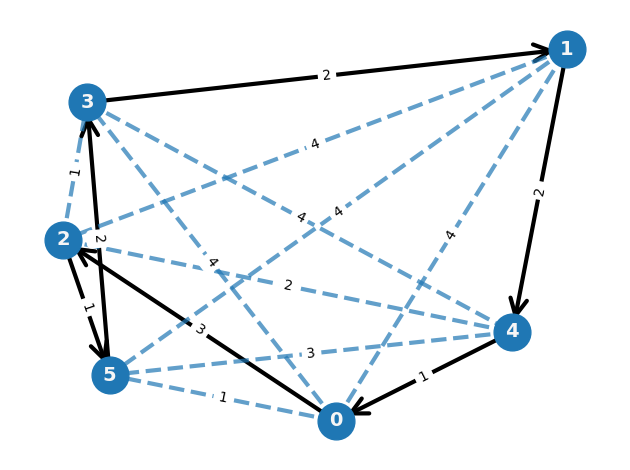

In [9]:
tsp_viz(G1, path)

### Task 1

Find the optimal route for the given graph using simulated annealer and the built-in function.

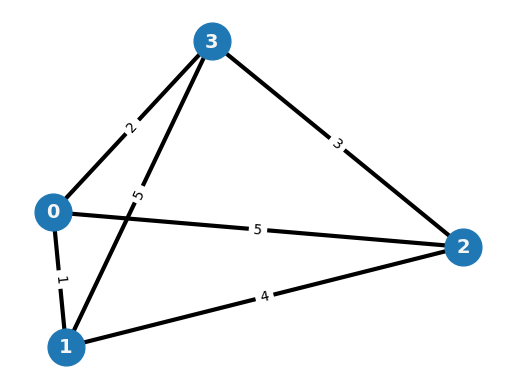

In [10]:
G = nx.Graph()
G.add_weighted_edges_from({(0, 1, 1), (0, 2, 5), (0, 3, 2), (1, 2, 4), (1, 3, 5), (2, 3, 3)})
graph_viz(G)

[0, 1, 2, 3]


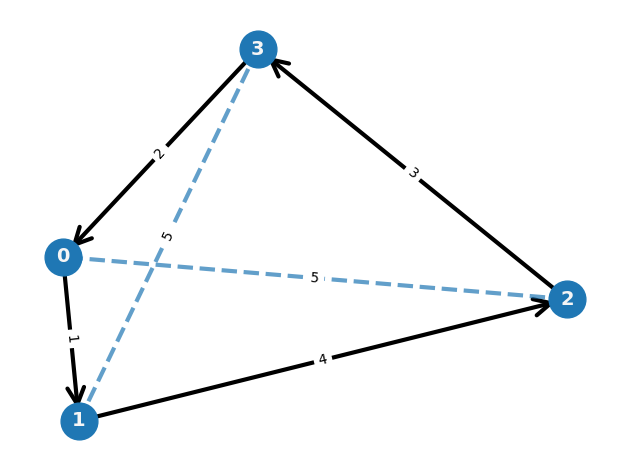

In [11]:
# Your code here
sampler = SimulatedAnnealingSampler()

path = dnx.traveling_salesperson(G, sampler, start=0)
print(path)
tsp_viz(G, path)

[click here for solution](BQM_TSP_Solutions.ipynb#Task1)

## Formulating BQM using OceanSDK functions

### Step 1 - Define an empty BQM and add the cost function you want to minimize

In case of TSP, this is the third term corresponding to the cost of the tour:

$$\sum_{ \substack{i,j=0\\i\neq j}}^{N-1} w_{ij} \sum_{t=0}^{N-1} x_{i,t} x_{j,t+1}$$ 

We use the function `add_quadratic` and provide the terms and the coefficient. Syntax is `(x_i,x_j,Q_{ij}`).

We will use the following graph.

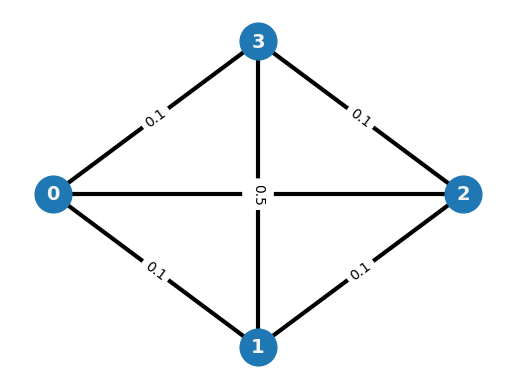

In [12]:
G = nx.Graph()
G.add_weighted_edges_from(
    {(0, 1, 0.1), (0, 2, 0.5), (0, 3, 0.1), (1, 2, 0.1), (1, 3, 0.5), (2, 3, 0.1)}
)
graph_viz(G)

In [13]:
bqm = BQM("BINARY")

N = len(G.nodes)
for i in range(N):
    for j in range(N):
        if i != j:
            for t in range(N - 1):
                bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t+1}", G[i][j]["weight"])

            # Remember that we were assuming N=0 in the sum
            bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", G[i][j]["weight"])

Note: In case your graph is not defined through networkx package but through a cost matrix `W`, you should replace `G[i][j]["weight"]` with `W[i][j]`.

### Step 2 - Add the Constraints to the BQM

Instead of the penalty method, BQM class allows us the functionality to add constraints directly.
#### Constraint 1

Only one city should be visited at a time.

$$\sum_{i=0}^{N-1}x_{i,t}=1 \text{ for all }t$$

We use the function `add_linear_equality_constraint` through which you can add linear equality constraints of the form 

$$c_1x_1+c_2x_2+\dots+c_nx_n+c=0.$$

The coefficients for the binary variables should be provided as a list

$$[(x_1,c_1), (x_2,c_2), \dots, (x_n,c_n)] $$

followed by the constant term $c$ and the `lagrange_multiplier` parameter.

Lagrange multipler is exactly the penalty coefficient we have seen so far. 

Penalty method is implemented by Ocean automatically.

Here is an example:

In [14]:
l1 = 5
for t in range(N):
    c1 = [(f"x_{i}_{t}", 1) for i in range(N)] #coefficient list
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=l1)

#### Constraint 2

Each city should be visited one and only once.

$$\sum_{t=0}^{N-1}x_{i,t}=1 \text{ for all }i$$

### Task 2

Add the second constraint to the BQM. Let langrange multiplier = 5.

In [16]:

#Your code here
for i in range(N):
    second_constraint = [(f"x_{i}_{t}", 1) for t in range(N)]
    bqm.add_linear_equality_constraint(second_constraint, constant = -1, 
                                         lagrange_multiplier = l1)

[click here for solution](BQM_TSP_Solutions.ipynb#Task2)

### Step 3 - Solve the BQM

We are going to use the `SimulatedAnnealingSampler` to solve the BQM.

In [18]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=1000)
print(sampleset.truncate(10))
print()
print(sampleset.first.sample)

  x_0_0 x_0_1 x_0_2 x_0_3 x_1_0 x_1_1 x_1_2 x_1_3 ... x_3_3 energy num_oc.
0     0     1     0     0     0     0     1     0 ...     0    0.4       1
1     0     0     1     0     0     0     0     1 ...     0    0.4       1
2     0     1     0     0     0     0     1     0 ...     0    0.4       1
3     0     0     0     1     0     0     1     0 ...     0    0.4       1
4     0     1     0     0     0     0     1     0 ...     0    0.4       1
5     0     0     1     0     0     0     0     1 ...     0    0.4       1
6     0     0     1     0     0     0     0     1 ...     0    0.4       1
7     1     0     0     0     0     0     0     1 ...     0    0.4       1
8     0     1     0     0     0     0     1     0 ...     0    0.4       1
9     0     1     0     0     0     0     1     0 ...     0    0.4       1
['BINARY', 10 rows, 10 samples, 16 variables]

{'x_0_0': 0, 'x_0_1': 1, 'x_0_2': 0, 'x_0_3': 0, 'x_1_0': 0, 'x_1_1': 0, 'x_1_2': 1, 'x_1_3': 0, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2'

### Step 4 -  Interpret and check the feasibility of the samples in the sampleset and find the optimum sample

As a result of simulated annealing, we obtain a sample where some of the variables are set to 1 and some of the variables are set to 0. 



Given a sample, we may want to check if it corresponds to a feasible solution or not, i.e. whether each city is visited exactly once and at each time point exactly one city is visited.

### Task 3

Write a Python function named `is_sample_feasible` that takes as parameter a sample containing binary variables named `x_i_p` and their values and the number of cities, and returns True if the sample corresponds to a feasible path and false otherwise.

In [19]:
# Your code here

def is_sample_feasible(first_sample, N):
    for t in range(N):
        isum = 0
        for i in range(N):
            isum += first_sample[f"x_{i}_{t}"]
        if isum != 1:
            return False
    for i in range(N):
        tsum = 0
        for t in range(N):
            tsum += first_sample[f"x_{i}_{t}"]
        if tsum != 1:
            return False
    return True

In [20]:
first_sample = sampleset.first.sample
is_sample_feasible(first_sample,N)

True

[click here for solution](BQM_TSP_Solutions.ipynb#Task3)

In case the first sample is not feasible, we may search for another solution among the sampleset which is feasible. This can be accomplished by the following code:

In [21]:
def best_solution(sampleset, N):
    for sample, energy in sampleset.data(fields=["sample", "energy"]):
        if is_sample_feasible(sample,N):
            return sample, energy
    return None, None

In [22]:
best_solution(sampleset, N)

({'x_0_0': 0,
  'x_0_1': 1,
  'x_0_2': 0,
  'x_0_3': 0,
  'x_1_0': 0,
  'x_1_1': 0,
  'x_1_2': 1,
  'x_1_3': 0,
  'x_2_0': 0,
  'x_2_1': 0,
  'x_2_2': 0,
  'x_2_3': 1,
  'x_3_0': 1,
  'x_3_1': 0,
  'x_3_2': 0,
  'x_3_3': 0},
 0.4000000000001478)

---

Suppose we verified that the sample is feasible. Then we would like to obtain the path it corresponds to.

In the next Task, your goal is to convert a given sample into a path in the form of a list containing city numbers. 

### Task 4

Write a Python function named `sample_to_path` that takes as parameter a sample containing binary variables named `x_i_p` and their values and the number of cities, and returns a list of cities corresponding to the sample. 

In [27]:
def sample_to_path(sample,N):
    
    #Your code here
    path = []
    for t in range(N):
        for i in range(N):
            if sample[f"x_{i}_{t}"] == 1:
                path.append(i)
                break
    
    return path

In [28]:
path = sample_to_path(first_sample,N)
print(path)

[3, 0, 1, 2]


[click here for solution](BQM_TSP_Solutions.ipynb#Task4)

---

The energy value of the sample gives us the total cost of the tour, where it is 0.4 in this case.

In [29]:
sampleset.first.energy

0.4000000000001478

Note that in case some constraint is violated, the energy value gives does not exactly give the cost, but cost + the penalty incurred.

### Step 5 - Visualize the Output

Since we have obtained the path as a list of cities, we can use `tsp_viz` function to visualize the result.

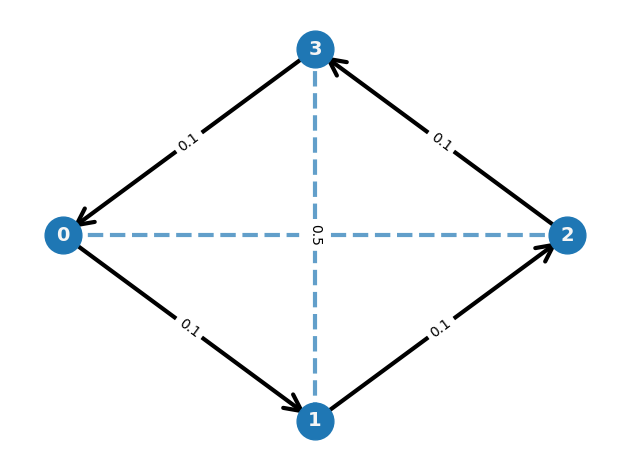

In [30]:
tsp_viz(G, path)

### Task 5

Write a function named `tsp_bqm` that takes as parameter a networkx graph G and the penalty coefficient and returns the binary quadratic model for the travelling salesmen problem.

In [40]:
def tsp_bqm(G, P):
    bqm = BQM("BINARY")
    N = len(G.nodes)
    bqm_dict = {}
    for i in range(N):
        for j in range(N):
            if i != j:
                for t in range(N-1):
                    bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t}", G[i][j]["weight"])
                bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", G[i][j]["weight"])


    for t in range(N):
        c1 = [(f"x_{i}_{t}", 1) for i in range(N)] #coefficient list
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=P)

    
    for i in range(N):
        second_constraint = [(f"x_{i}_{t}", 1) for t in range(N)]
        bqm.add_linear_equality_constraint(second_constraint, constant = -1, 
                                             lagrange_multiplier = P)

    return bqm

[click here for solution](BQM_TSP_Solutions.ipynb#Task5)

### Task 6

For the graph `G1` defined above, construct the bqm and find the optimal path.

Don't forget to set the penalty coefficient to a suitable value.

Let's define the graph again.

In [41]:
np.random.seed(45)
G1 = nx.complete_graph(6)
for u, v in G1.edges():
    G1[u][v]["weight"] = np.random.randint(1, 5)
N = len(G1.nodes)

In [42]:
#Get bqm
bqm = tsp_bqm(G1, P = 5)

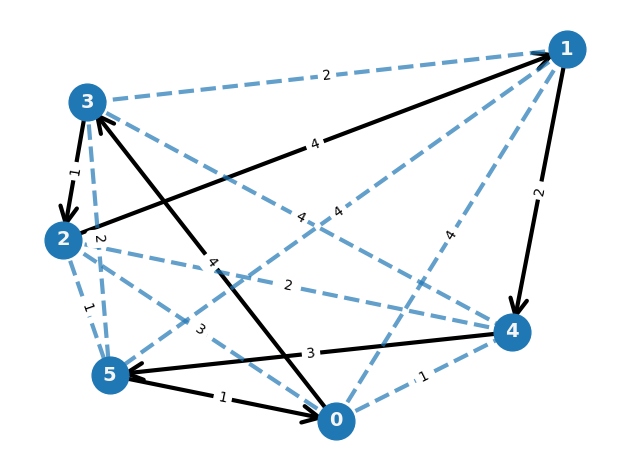

In [47]:
#Use simulated annealing and get sampleset
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads = 1000)
path = sample_to_path(sampleset.first.sample, N)
tsp_viz(G1, path)

In [ ]:
#Get the first sample and check if it is feasible



In [ ]:
#Convert sample into path



In [ ]:
#Print the energy of the sample corresponding to the cost of the route



In [ ]:
#Visualize the result



[click here for solution](BQM_TSP_Solutions.ipynb#Task6)

## Formulating BQM from scratch (Optional)

Although we have built-in functions to define binary quadratic model through inequality and equality constraints, one can also define a BQM from scratch. Now we will see how we can accomplish this.

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(
    {(0, 1, 0.1), (0, 2, 0.5), (0, 3, 0.1), (1, 2, 0.1), (1, 3, 0.5), (2, 3, 0.1)}
)
graph_viz(G)

### Step 1 - Define QUBO

Define the QUBO in dictionary, recalling the following:

- Each $x_{i,t}$ appears with coefficient $-2P$.
- For each fixed $t$, all possible 2-combinations of $x_{i,t}$ appears with coefficient $2P$.
- For each fixed $i$, all possible 2-combinations of $x_{i,t}$ appears with coefficient $2P$.
- Each $x_{i,t} x_{j,t+1}$ appears with the coeeficient $w_{ij}$.
- There is a constant coefficient of $2NP$.


In [ ]:
d = {}
P = 5

N = len(G.nodes)

for i in range(N):
    for t in range(N):
        d[(f"x_{i}_{t}", f"x_{i}_{t}")] = -2 * P

for t in range(N):
    for i in range(N):
        for j in range(i + 1, N):
            d[(f"x_{i}_{t}", f"x_{j}_{t}")] = 2 * P

for t in range(N):
    for tp in range(t + 1, N):
        for i in range(N):
            d[(f"x_{i}_{t}", f"x_{i}_{tp}")] = 2 * P

for i in range(N):
    for j in range(N):
        if i != j:
            d[(f"x_{i}_{N-1}", f"x_{j}_{0}")] = G[i][j]["weight"]
            for t in range(N - 1):
                d[(f"x_{i}_{t}", f"x_{j}_{t+1}")] = G[i][j]["weight"]

### Step 2 - Create BQM instance out of QUBO

Create an instance of BQM from the QUBO dictionary. 

Don't forget to add the offset.

In [ ]:
bqm = BQM.from_qubo(d, offset = 2*N*P)

### Step 3 - Solve the BQM 

Solve it using `SimulatedAnnealer()`. 


In [ ]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=1000)
print(sampleset.truncate(10))

You can also check the corresponding $Q$ matrix.

In [ ]:
matrix = bqm.to_numpy_matrix(bqm.variables)
print(matrix)

### Step 4 -  Interpret and check the feasibility of the samples in the sampleset and find the optimum sample

Obtain the optimum sample from the sampleset and visualize the result.

In [ ]:
first_sample = sampleset.first.sample
is_sample_feasible(first_sample,N)

In [ ]:
path = sample_to_path(first_sample,N)
print(path)

### Step 5 - Visualize the result

In [ ]:
tsp_viz(G, path)